<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/raman_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os

!git clone https://github.com/luancordeiro/lidarpy.git
os.chdir("lidarpy")

Cloning into 'lidarpy'...
remote: Enumerating objects: 434, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 434 (delta 146), reused 143 (delta 75), pack-reused 205
Receiving objects: 100% (434/434), 68.13 MiB | 22.61 MiB/s, done.
Resolving deltas: 100% (290/290), done.


In [5]:
from lidarpy import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()

# Removing the background noise and grouping the bins

In [53]:
from lidarpy.data.manipulation import remove_background, groupby_nbins

nbins = 10

lidar_clean = (lidar_data
               .pipe(remove_background, [25_000, 80_000])
               .pipe(groupby_nbins, nbins))

In [59]:
da_raman = (lidar_clean
            .mean("time")
            [[1, 3], 1100 // nbins:2400 // nbins].rolling(altitude=5)
            .mean()
            .dropna("altitude"))
z_raman = da_raman.coords["altitude"]

# Getting the atmospheric data

In [60]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

temperature = f_temp(z_raman)
pressure = f_pres(z_raman)

# Raman inversion

In [61]:
from lidarpy.inversion.raman import Raman, diff_

raman = Raman(da_raman,
              355,
              387,
              0,
              pressure,
              temperature,
              10_000)

In [64]:
alpha, beta, lr = raman.fit(diff_window=9)

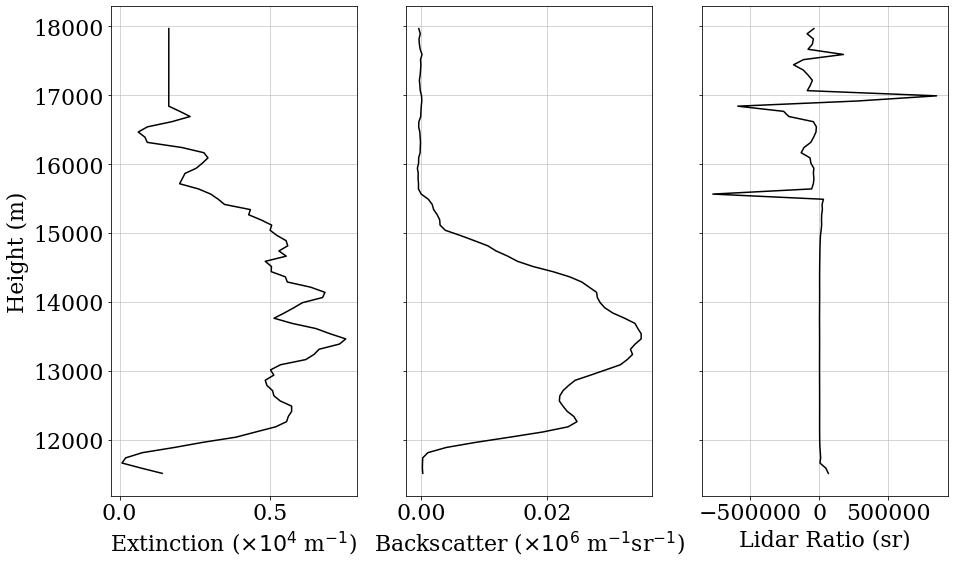

In [65]:
from lidarpy.plot.plotter import plot_3graph_std

ind = (z_raman >= 11500)

plot_3graph_std(z_raman[ind], 
                alpha[ind], 
                beta[ind], 
                lr[ind])